In [1]:
import sys
import os
sys.path.insert(0, '../magcolloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloids as mgc
import matplotlib as mpl
import string as st
import support as sp

from tqdm.auto import tqdm

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2

In [2]:
mpl.rc("figure",dpi=150)
mpl.rc("figure",figsize=(3,2))
mpl.rc("text",usetex=True)

## Normalization Parameters

In [3]:
%%time
directory = "/media/Antonio/Dynamic/DimerCurrents/Processed/"

trj_file = os.path.join(directory, "23_08_01_Script10_currents.hdf")
index = pd.read_hdf(trj_file, key = "index")

CPU times: user 23.5 ms, sys: 9.08 ms, total: 32.6 ms
Wall time: 155 ms


In [4]:
%%time
trj = pd.read_hdf(trj_file, key = index.iloc[0].file)
bnd = pd.read_hdf(trj_file, key = "bounds/"+index.iloc[0].file)

CPU times: user 183 ms, sys: 265 ms, total: 448 ms
Wall time: 16.2 s


In [5]:
freq = 3 # Hz
N = len(trj.index.get_level_values("id").unique())
area = ((bnd.x_max-bnd.x_min)*(bnd.y_max-bnd.y_min)).iloc[0]
factor = freq*np.sqrt(area/N/np.sqrt(3))

In [6]:
factor

9.561144699114461

## Read Data

In [7]:
%%time
directory = "/media/Antonio/Dynamic/DimerCurrents/Processed"

aggregate_file = os.path.join(directory, "23_08_01_Script11_currents_vs_time.hdf")
data_IvsT = pd.read_hdf(aggregate_file,
                 key = "current_vs_time")
data_IvsT = data_IvsT.reorder_levels(["parity","tilt","seed","time"]).sort_index()

data_IvsT[["I_x","I_y","I"]] = data_IvsT[["I_x","I_y","I"]]/factor
data_IvsT[["var_I_x","var_I_y","var_I"]] = data_IvsT[["I_x","I_y","I"]]/factor**2

CPU times: user 1.62 s, sys: 921 ms, total: 2.54 s
Wall time: 31.4 s


In [8]:
data_IvsT.head()

I_x       I_y   I   var_I_x   var_I_y  var_I
parity tilt seed  time                                                     
even   0    61169 0.0000       NaN       NaN NaN       NaN       NaN    NaN
                  0.0167  2.317660  0.629493 NaN  0.025353  0.006886    NaN
                  0.0334  2.150320  1.140412 NaN  0.023522  0.012475    NaN
                  0.0501  0.412801  0.327185 NaN  0.004516  0.003579    NaN
                  0.0668 -0.652357 -0.472600 NaN -0.007136 -0.005170    NaN

(-0.2, 0.2)

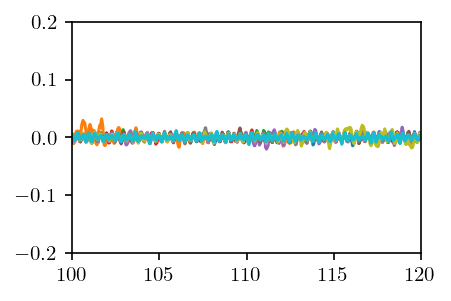

In [9]:
for seed, I_i in data_IvsT.loc[("even",0)].groupby("seed"):
    plt.plot(I_i.loc[seed].I_x.rolling(20).mean())
    
plt.xlim([100,120])
plt.ylim(-0.2,0.2)

In [10]:
currents_aggregate = data_IvsT.groupby(["parity","tilt","time"]).mean()
currents_aggregate[["I_x","I_y"]] = currents_aggregate.rolling(20).mean()[["I_x","I_y"]]
currents_aggregate["var_I"] = data_IvsT.groupby(["parity","tilt","time"]).var().I

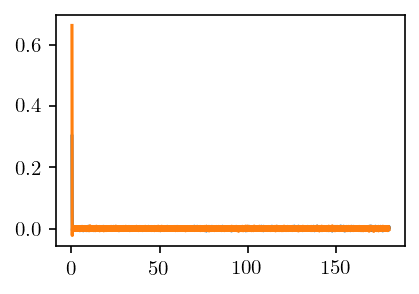

In [11]:
plt.plot(currents_aggregate["I_x"].loc[("even",0)])
plt.plot(currents_aggregate["I_y"].loc[("even",0)])

In [12]:
currents_aggregate.head()

I_x  I_y   I   var_I_x   var_I_y  var_I
parity tilt time                                           
even   0    0.0000  NaN  NaN NaN       NaN       NaN    NaN
            0.0167  NaN  NaN NaN  0.024949  0.006770    NaN
            0.0334  NaN  NaN NaN  0.023473  0.012287    NaN
            0.0501  NaN  NaN NaN  0.004974  0.003940    NaN
            0.0668  NaN  NaN NaN -0.007090 -0.005196    NaN

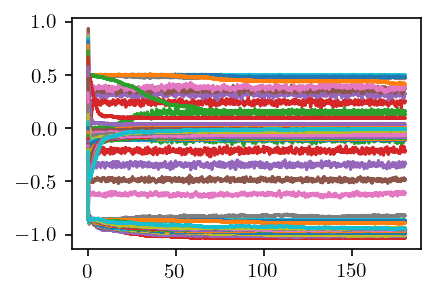

In [13]:
for i, data_i in currents_aggregate.loc["even"].groupby("tilt"):
    L = plt.plot(currents_aggregate.loc["even"].loc[i].I_x)
    plt.plot(currents_aggregate.loc["even"].loc[i].I_y,
            color = L[0].get_color())

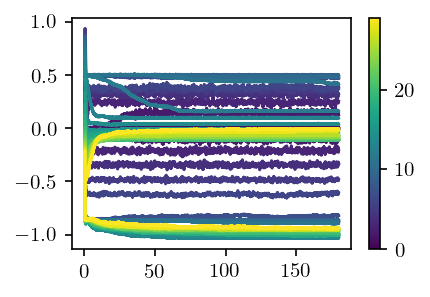

In [14]:
tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["viridis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for i, data_i in currents_aggregate.loc["even"].groupby("tilt"):
    plt.plot(currents_aggregate.loc[("even",i)].I_x,
            color = cmap(norm(i)))
    plt.plot(currents_aggregate.loc[("even",i)].I_y,
            color = cmap(norm(i)))
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax = plt.gca())

In [15]:
currents_aggregate["I"] = currents_aggregate.eval("sqrt(I_x**2+I_y**2)")

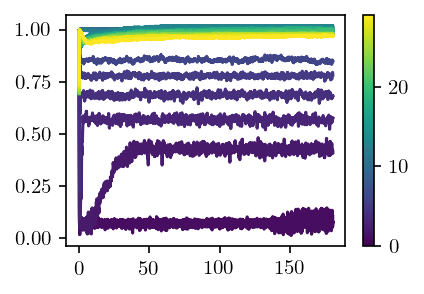

In [16]:
tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["viridis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for i, data_i in currents_aggregate.loc["even"].groupby("tilt"):
    
    I = np.sqrt(currents_aggregate.loc[("even",i)].I)

    plt.plot(I,color = cmap(norm(i)))
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax = plt.gca())

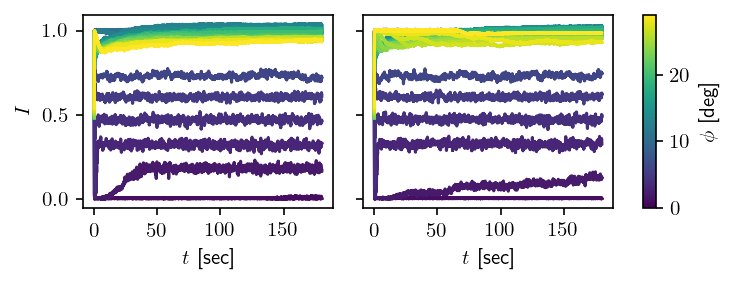

In [17]:
fig, ax = plt.subplots(1,3, figsize=(5,2),
                       width_ratios = [1,1, 0.05],
                       tight_layout=True)

tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["viridis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for i, data_i in currents_aggregate.loc["even"].groupby("tilt"):

    ax[0].plot(currents_aggregate.loc[("even",i)].I ,color = cmap(norm(i)))
    
    ax[1].plot(currents_aggregate.loc[("odd",i)].I ,color = cmap(norm(i)))
    
    
ax[0].set_ylabel("$I$")
ax[0].set_xlabel("$t$ [sec]")
ax[1].set_xlabel("$t$ [sec]")

ax[1].set_ylim(ax[0].get_ylim())
ax[1].tick_params("y",labelleft=False)
#ax[1].set_yticks([])
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax = ax[2],
             label = "$\phi$ [deg]")


### Save the smooth dataset

In [18]:
currents_aggregate.to_hdf(aggregate_file,
                 key = "current_vs_time_smooth")

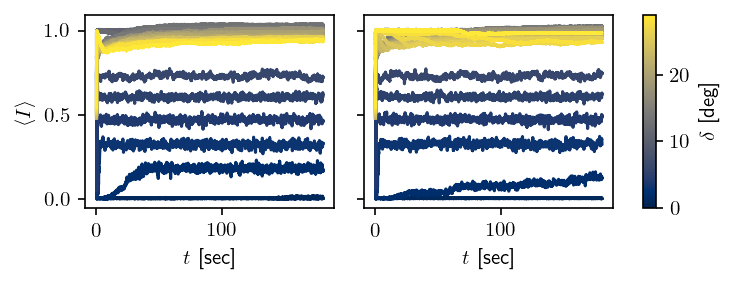

In [19]:
data_IvsT_smooth = pd.read_hdf(aggregate_file,
                 key = "current_vs_time_smooth")

fig, ax = plt.subplots(1,3, figsize=(5,2),
                       width_ratios = [1,1, 0.05],
                       tight_layout=True, facecolor="white")

tilts = data_IvsT.index.get_level_values("tilt").unique()
cmap = mpl.colormaps["cividis"]
norm = mpl.colors.Normalize(min(tilts), max(tilts))

for phi in np.sort(tilts):

    ax[0].plot(data_IvsT_smooth.loc["even"].loc[phi].I, color = cmap(norm(phi)))

    ax[1].plot(data_IvsT_smooth.loc["odd"].loc[phi].I, color = cmap(norm(phi)))
    
    
ax[0].set_ylabel(r"$\left<I\right>$")
ax[0].set_xlabel("$t$ [sec]")
ax[1].set_xlabel("$t$ [sec]")

ax[1].set_ylim(ax[0].get_ylim())
ax[1].tick_params("y",labelleft=False)
#ax[1].set_yticks([])
    
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax = ax[2],
             label = "$\delta$ [deg]")

plt.savefig("../Plots/current_timeseries.pdf")

In [20]:
data_IvsT_smooth.loc["even"].I.dropna().unstack().transpose().to_csv(
    "../Plots/current_timeseries_even.dat", sep = "\t")

data_IvsT_smooth.loc["odd"].I.dropna().unstack().transpose().to_csv(
    "../Plots/current_timeseries_odd.dat", sep = "\t")

# Visualize final value of the current vs tilt angle $\phi$

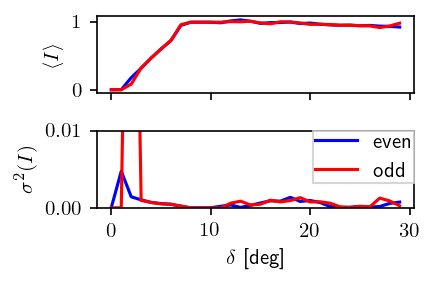

In [21]:
data_IvsPhi = data_IvsT_smooth.query("time>50").groupby(["parity","tilt"]).mean()
#data_IvsPhi_var = data_IvsT_smooth.query("time>50").groupby(["parity","tilt"]).var()

fig, ax = plt.subplots(2,1, sharex=True,
                       figsize=(3,2), facecolor="white",
                       tight_layout=True)

color = ["blue","red"]

ax[0].plot(data_IvsPhi.loc["even"].I,color = color[0])
ax[0].plot(data_IvsPhi.loc["odd"].I,color = color[1])


ax[1].plot(data_IvsPhi.loc["even"].var_I, color[0], label="even")
ax[1].plot(data_IvsPhi.loc["odd"].var_I, color[1], label="odd")

ax[1].set_xlabel("$\delta$ [deg]")
ax[1].set_ylabel("$\sigma^2(I)$")
ax[0].set_ylabel(r"$\left<I\right>$")

ax[1].set_ylim(0,0.01)

ax[1].legend(
    fancybox=False,
    borderpad=0.1,
    bbox_to_anchor=(1,1),borderaxespad=0
            )

plt.savefig("../Plots/current_vs_tilt_f3.pdf")

In [22]:
data_IvsPhi.I.unstack().transpose().to_csv(
    "../Plots/current_vs_tilt_f3.dat", sep="\t")
data_IvsPhi.var_I.unstack().transpose().to_csv(
    "../Plots/current_vs_tilt_f3_var.dat", sep="\t")